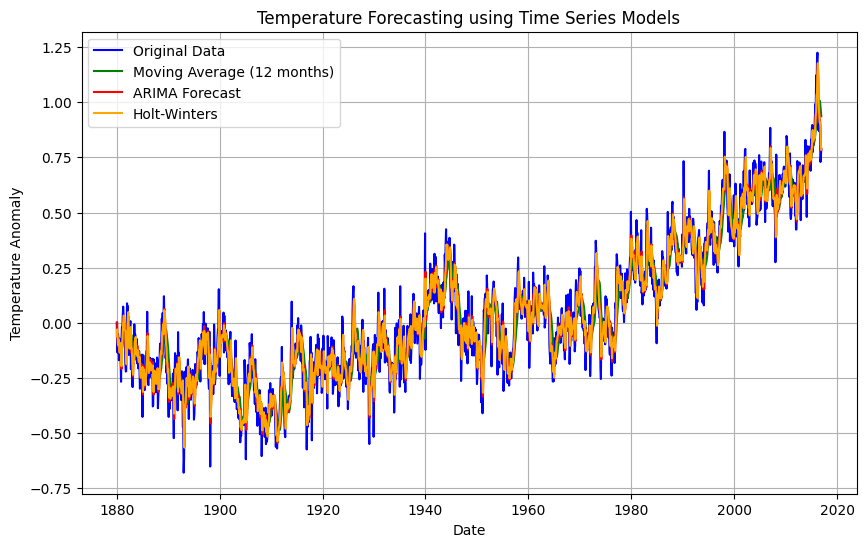

✅ Decision Tree Accuracy for Risk Assessment: 0.96


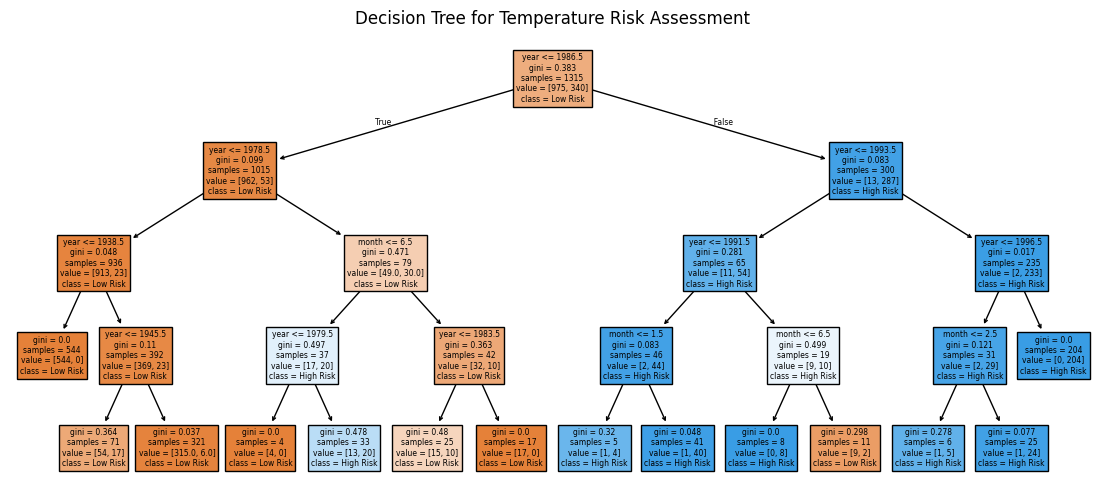

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ----------------------------------------
# 1. Load the Dataset
# ----------------------------------------
file_path = '/content/monthly_csv.csv'  # Change this to your dataset path
df = pd.read_csv(file_path, parse_dates=['Date'])

# Keep only relevant columns
df = df[['Date', 'Mean']]
df.dropna(inplace=True)
df.set_index('Date', inplace=True)

# Remove duplicates
df = df[~df.index.duplicated(keep='first')]

# Resample to monthly mean (if not already monthly)
df = df.resample('MS').mean()

# ----------------------------------------
# 2. Moving Average
# ----------------------------------------
df['MA_12'] = df['Mean'].rolling(window=12).mean()

# ----------------------------------------
# 3. ARIMA
# ----------------------------------------
arima_model = ARIMA(df['Mean'], order=(5,1,0))
arima_result = arima_model.fit()
df['ARIMA_Forecast'] = arima_result.predict(start=1, end=len(df)-1, typ='levels')

# ----------------------------------------
# 4. Holt-Winters
# ----------------------------------------
hw_model = ExponentialSmoothing(df['Mean'], trend='add', seasonal='add', seasonal_periods=12)
hw_fit = hw_model.fit()
df['Holt_Winters'] = hw_fit.fittedvalues

# ----------------------------------------
# 5. Visualize Forecasts
# ----------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df['Mean'], label='Original Data', color='blue')
plt.plot(df['MA_12'], label='Moving Average (12 months)', color='green')
plt.plot(df['ARIMA_Forecast'], label='ARIMA Forecast', color='red')
plt.plot(df['Holt_Winters'], label='Holt-Winters', color='orange')
plt.legend()
plt.title('Temperature Forecasting using Time Series Models')
plt.xlabel('Date')
plt.ylabel('Temperature Anomaly')
plt.grid(True)
plt.show()

# ----------------------------------------
# 6. Decision Tree - Risk Assessment
# ----------------------------------------
df_risk = df.copy()
threshold = df_risk['Mean'].quantile(0.75)
df_risk['risk'] = df_risk['Mean'].apply(lambda x: 1 if x > threshold else 0)

df_risk['month'] = df_risk.index.month
df_risk['year'] = df_risk.index.year

X = df_risk[['month', 'year']]
y = df_risk['risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"✅ Decision Tree Accuracy for Risk Assessment: {acc:.2f}")

plt.figure(figsize=(14, 6))
plot_tree(clf, feature_names=X.columns, class_names=["Low Risk", "High Risk"], filled=True)
plt.title("Decision Tree for Temperature Risk Assessment")
plt.show()
